In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from scipy.cluster.hierarchy import linkage # fcluster, to_tree, dendrogram, 
from scipy.stats import pearsonr
import re
import matplotlib.gridspec as gridspec

In [2]:
from module.PGMD import SSE_read, pair_PGMD

/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from module.sse_matching_master_draft import *

In [4]:
from module.cluster_utils import dendrogram_clustering


In [ ]:
save_things = False

# data

In [6]:
filename = '../../data/proteins/Dataset 1--PDB ID of circular permutaion of this work.txt'

with open(filename) as f:
    lines = f.readlines()
cp_ids = [re.split('\n|/|.pdb', i)[1] for i in lines]

In [7]:
filename = '../../data/proteins/Dataset 2--TM-Value for Circular permutation pairs by TMalign and TMalign-CP of this work.txt'

circular_pairs = pd.read_csv(filename, delimiter=' ', header=None)
circular_pairs.columns = ['id_1', 'id_2', 'TMalign', 'TMalignCP']

circular_pairs.id_1 = np.stack(circular_pairs.id_1.str.split('/|.pdb'))[:,1]

circular_pairs.id_2 = np.stack(circular_pairs.id_2.str.split('/|.pdb'))[:,1]

In [8]:
hq_pairs= pd.read_csv('../../data/proteins/chen_seqcp_2023/high_quality.csv', header=None)
hq_pairs.columns=['id_1', 'id_2']
hq_pairs['Q'] = 'high'
hq_pairs['id_1'] = hq_pairs['id_1'].apply(lambda x: x[:-1] + '_' + x[-1] if not x[-1]=='_' else x + 'A')
hq_pairs['id_2'] = hq_pairs['id_2'].apply(lambda x: x[:-1] + '_' + x[-1] if not x[-1]=='_' else x + 'A')

marginal_pairs= pd.read_csv('../../data/proteins/chen_seqcp_2023/marginal.csv', header=None)
marginal_pairs.columns=['id_1', 'id_2']
marginal_pairs['Q'] = 'marginal'
marginal_pairs['id_1'] = marginal_pairs['id_1'].apply(lambda x: x[:-1] + '_' + x[-1] if not x[-1]=='_' else x + 'A')
marginal_pairs['id_2'] = marginal_pairs['id_2'].apply(lambda x: x[:-1] + '_' + x[-1] if not x[-1]=='_' else x + 'A')

chen_pairs = pd.concat([hq_pairs, marginal_pairs])


# if the chain was not specified, take A chain

# Run for all circular permutations: 

In [9]:
pairpathpf = f'../../data/proteins/100_sec_map/sscm'
pairopathpf = '../../data/proteins/100_sec_map/orientation'

In [10]:
chainval, alpha, gamma = 0.733152,	2.735147,	1.681227 # 1.2 , 4.2, np.sqrt(2) # 2.371547,	7.207803,	0.784998 #   0.72020553, 3.52626461, 2.93014126 #  # 

type_to_tex_dict = {'E':r'$\blacksquare$', 'H':r'$\bigcirc$'}
sdict = {'E':'s', 'H':'o'}


In [11]:
sse_inst = SSE_read(fpathprefix=pairpathpf, 
                    opathprefix=pairopathpf, 
                    fpathext='txt', 
                    opathext='txt', 
                    chainval=chainval, 
                    sim_func=invd_sim_func, 
                    chain_func=forward_chain_adj_prep, 
                    threshold=7.5)

pgmd_inst = pair_PGMD(assembly_func=sse_inst.assemble_strict) 


In [12]:
# cp_pairs = circular_pairs[['id_1', 'id_2']].values
# 
cp_pairs = chen_pairs[['id_1', 'id_2']].values


In [13]:
# sscm = [f'/Users/ssm47/Documents/contact_maps/data/100_sec_map/sscm/{i}.txt' for i in list(set(chen_pairs.id_1) | set(chen_pairs.id_2))]

# orientation = [f'/Users/ssm47/Documents/contact_maps/data/100_sec_map/orientation/{i}.txt' for i in list(set(chen_pairs.id_1) | set(chen_pairs.id_2))]

# with open("../../data/sscm_files_to_save.txt", "w") as f:
#     for item in sscm:
#         f.write(f"{item}\n")

# with open("../../data/orientation_files_to_save.txt", "w") as f:
#     for item in orientation:
#         f.write(f"{item}\n")

In [14]:
# sids_list = []
# perm_inds_list = []
# first_n = None
# qs = []
# output = []
# for ids, q in list(zip(cp_pairs[:first_n], chen_pairs.Q.values)):
#     id_1, id_2 = ids  
#     sse_inst.reset_SSE()
#     pgmd_inst.refresh()
#     try:
#         container = pgmd_inst.get_container(pids=[id_1, id_2],)
#         if (container[0][1].shape[1]==0) or (container[1][1].shape[1]==0): # if we don't have a contact map file for one of the proteins, then move on...
#             # sids_list.append([id_1, id_2])
#             # perm_inds_list.append(np.nan)
#             output.append({'ids':ids, 'perm_inds':np.nan, 'Q':q})

#             # pr_values.append([np.nan, np.nan])
#             continue

#         run_gm_output = pgmd_inst.run_gm(pids=[id_1, id_2], alpha=alpha, gamma=gamma, use_lengths=True, match_args=None)
#         perm_inds = run_gm_output['perm_inds']
#         # perm_inds_list.append(perm_inds)
#         sids = pgmd_inst.sorted_ids # sort the ids
#         # sids_list.append(sids)
#         output.append({'ids':sids, 'perm_inds':perm_inds, 'Q':q})
#     except:
#         print(id_1, id_2, 'Failed')
#         continue

# matching_df = pd.DataFrame(output).dropna()
# matching_df = matching_df[matching_df.perm_inds.apply(len) > 2]

# # ~4 mins 40s
# matching_df.to_feather('../../data/proteins/processed/circular_perms.feather')


In [15]:
matching_df = pd.read_feather('../../data/proteins/processed/circular_perms.feather')

In [16]:
perm_inds_arr = matching_df.perm_inds.dropna().values

disc_inds = []
cp_pstats = []
cp_pvals = []
up_pstats = []
up_pvals = []

for perm_ind in perm_inds_arr:
    disc_ind = np.argmin(perm_ind[1:] - perm_ind[:-1]) # index with the largest negative value
    circularly_permuted = np.concatenate([perm_ind[disc_ind+1:], perm_ind[:disc_ind+1]])
    pstat, pvalue = pearsonr(circularly_permuted, np.arange(len(circularly_permuted)))
    up_pstat, up_pvalue = pearsonr(perm_ind, np.arange(len(perm_ind)))

    disc_inds.append(disc_ind)
    cp_pstats.append(pstat)
    cp_pvals.append(pvalue)
    up_pstats.append(up_pstat)
    up_pvals.append(up_pvalue)


matching_df['disc_ind'] = disc_inds
matching_df['p_pearsonr'] = cp_pstats
matching_df['p_sig'] = cp_pvals

matching_df['up_pearsonr'] = up_pstats
matching_df['up_sig'] = up_pvals

In [17]:
matching_df['p_sig'] = matching_df['p_sig'] < 1e-5

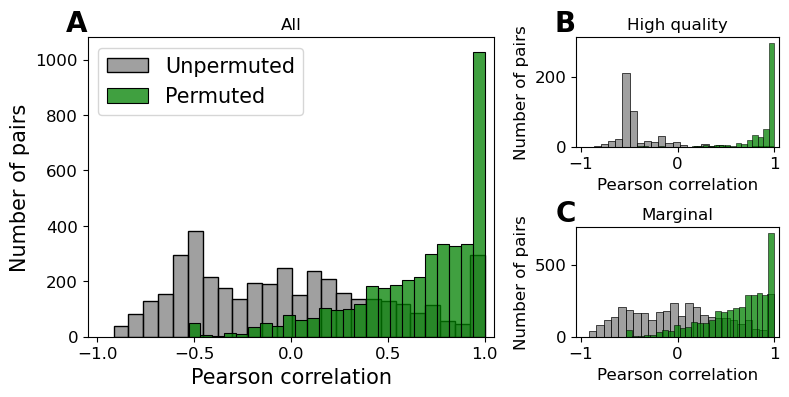

In [19]:
# fig, ax = plt.subplots(figsize=(5,4))
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  # 2 rows, 2 columns

ax1 = fig.add_subplot(gs[:, 0]) 
ax2 = fig.add_subplot(gs[0, 1])  
ax3 = fig.add_subplot(gs[1, 1])  


sns.histplot(matching_df, x='up_pearsonr', bins=25, label='Unpermuted', ax=ax1, color='grey')
sns.histplot(matching_df, x='p_pearsonr', bins=25, label='Permuted', ax=ax1, color='green')
ax1.set_xlabel('Pearson correlation', size=15)
ax1.set_ylabel('Number of pairs', size=15)
ax1.tick_params(axis='x', labelsize=12)  
ax1.tick_params(axis='y', labelsize=12)  
ax1.legend(fontsize=15)
ax1.set_xlim([-1.05, 1.05])
ax1.set_title('All')


sns.histplot(matching_df.query('Q=="high"'), x='up_pearsonr', bins=25, label='Unpermuted', ax=ax2, color='grey')
sns.histplot(matching_df.query('Q=="high"'), x='p_pearsonr', bins=25, label='Permuted', ax=ax2, color='green')
ax2.set_title('High quality')
ax2.set_xlabel('Pearson correlation', size=12)
ax2.set_ylabel('Number of pairs', size=12)
ax2.tick_params(axis='x', labelsize=12)  
ax2.tick_params(axis='y', labelsize=12)  
ax2.set_xlim([-1.05, 1.05])


sns.histplot(matching_df.query('Q=="marginal"'), x='up_pearsonr', bins=25, label='Unpermuted', ax=ax3, color='grey')
sns.histplot(matching_df.query('Q=="marginal"'), x='p_pearsonr', bins=25, label='Permuted', ax=ax3, color='green')
ax3.set_title('Marginal')
ax3.set_xlabel('Pearson correlation', size=12)
ax3.set_ylabel('Number of pairs', size=12)
ax3.tick_params(axis='x', labelsize=12)  
ax3.tick_params(axis='y', labelsize=12)  
ax3.set_xlim([-1.05, 1.05])
# ax3.legend()


plt.tight_layout()
ax1.text(0, 1, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')
ax2.text(0, 1, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')
ax3.text(0, 1, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

if save_things:
    plt.savefig('../figures/chen_pearson_eval.png', dpi=300, bbox_inches='tight',)
    plt.savefig('../figures/chen_pearson_eval.pdf', dpi=300, bbox_inches='tight',)

plt.show()